# Choices: distance (local basis), feature 2 (salt bridges), down-up+ transition  

In [2]:
import numpy as np
import extq
import matplotlib.pyplot as plt
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../../")
import util
import kde

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


Load CV data

In [7]:
with np.load("../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cvs = f["arr_0"]

In [8]:
cvs.shape

(6580000, 2)

In [9]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

In [11]:
cv_trajs = np.split(cvs, traj_inds)

# Define states 

Up+ is given by the center corresponding to the homology model (Rong's presentation) and 1 stddev from trajectory 1043

In [13]:
dist = cvs[:, 0]
rot = cvs[:, 1]

# ellipse centered at (-3.836 , -45.73) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
down_ids = (
    (((dist + 3.836) / 0.574) ** 2 + ((rot + 45.73) / 8.21) ** 2) < 1
).nonzero()[0]

# ellipse centered at (4.895, 49) with radii 0.632 and 9.8 for up state
up_ids = ((((dist - 4.895) / 0.632) ** 2 + ((rot - 49) / 9.8) ** 2) < 1).nonzero()[0]

mask = np.ones(len(cvs), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
down = data_arr[down_ids]
up = data_arr[up_ids]
other = data_arr[mask]
down_cvs = cvs[down_ids]
up_cvs = cvs[up_ids]
other_cvs = cvs[mask]

assert (len(down) + len(up) + len(other)) == len(cvs)
print(f"Number of down structures:   {len(down)}")
print(f"Number of up+ structures:    {len(up)}")
print(f"Number of other structures:  {len(other)}")

Number of down structures:   82403
Number of up+ structures:    73071
Number of other structures:  6424526


### Averages with states

(array([ 4349.,  7789.,  9688., 10341.,  9401.,  8471.,  7597.,  6885.,
         5497.,  3053.]),
 array([39.204 , 41.1625, 43.121 , 45.0795, 47.038 , 48.9965, 50.955 ,
        52.9135, 54.872 , 56.8305, 58.789 ]),
 <BarContainer object of 10 artists>)

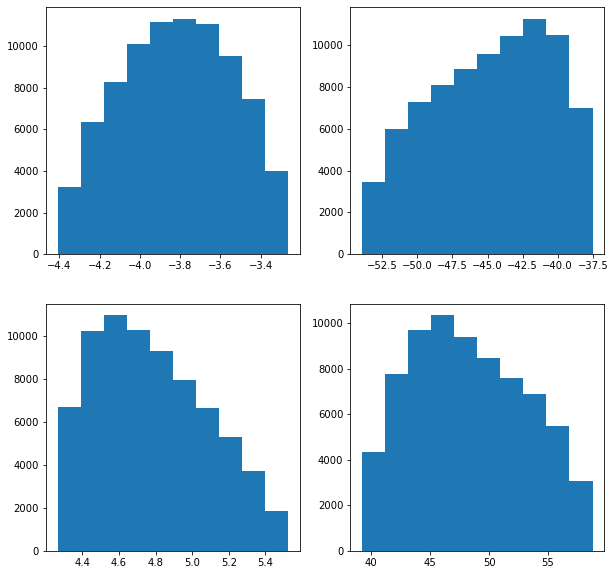

In [51]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].hist(down_cvs[:, 0])
axs[0][1].hist(down_cvs[:, 1])
axs[1][0].hist(up_cvs[:, 0])
axs[1][1].hist(up_cvs[:, 1])

In [ ]:
f, axs = plt.subplots(1, 2)

# Compute pairwise distances 

In [14]:
print(sklearn.get_config()["working_memory"])

1024


In [15]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

## Down state

In [16]:
d_down = []
counter = 0.0
tot = len(data_arr)
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.07% completed
0.15% completed
0.22% completed
0.30% completed
0.37% completed
0.45% completed
0.52% completed
0.59% completed
0.67% completed
0.74% completed
0.82% completed
0.89% completed
0.97% completed
1.04% completed
1.11% completed
1.19% completed
1.26% completed
1.34% completed
1.41% completed
1.49% completed
1.56% completed
1.63% completed
1.71% completed
1.78% completed
1.86% completed
1.93% completed
2.00% completed
2.08% completed
2.15% completed
2.23% completed
2.30% completed
2.38% completed
2.45% completed
2.52% completed
2.60% completed
2.67% completed
2.75% completed
2.82% completed
2.90% completed
2.97% completed
3.04% completed
3.12% completed
3.19% completed
3.27% completed
3.34% completed
3.42% completed
3.49% completed
3.56% completed
3.64% completed
3.71% completed
3.79% completed
3.86% completed
3.94% completed
4.01% completed
4.08% completed
4.16% completed
4.23% completed
4.31% completed
4.38% completed
4.46% completed
4.53% completed
4.60% completed
4.68% co

In [17]:
print(len(d_down), d_down[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
print(d_down_arr.shape)
print(np.max(d_down_arr[down_ids]))
d_down_arr[down_ids] = 0
print(np.max(d_down_arr[down_ids]))

print(d_down_arr.shape)

1347 (4886,)
(6580000, 1)
1.0814435
0.0
(6580000, 1)


In [18]:
np.save("../data/dist_down_feat2.npy", d_down_arr)

## Up state

In [20]:
d_up = []
counter = 0.0

for chunk in metrics.pairwise_distances_chunked(
    data_arr, up[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.08% completed
0.17% completed
0.25% completed
0.33% completed
0.42% completed
0.50% completed
0.59% completed
0.67% completed
0.75% completed
0.84% completed
0.92% completed
1.00% completed
1.09% completed
1.17% completed
1.26% completed
1.34% completed
1.42% completed
1.51% completed
1.59% completed
1.67% completed
1.76% completed
1.84% completed
1.93% completed
2.01% completed
2.09% completed
2.18% completed
2.26% completed
2.34% completed
2.43% completed
2.51% completed
2.60% completed
2.68% completed
2.76% completed
2.85% completed
2.93% completed
3.01% completed
3.10% completed
3.18% completed
3.27% completed
3.35% completed
3.43% completed
3.52% completed
3.60% completed
3.68% completed
3.77% completed
3.85% completed
3.94% completed
4.02% completed
4.10% completed
4.19% completed
4.27% completed
4.35% completed
4.44% completed
4.52% completed
4.61% completed
4.69% completed
4.77% completed
4.86% completed
4.94% completed
5.02% completed
5.11% completed
5.19% completed
5.28% co

In [21]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids]))
d_up_arr[up_ids] = 0
print(np.max(d_up_arr[up_ids]))

print(d_up_arr.shape)

1195 (5510,)
(6580000, 1)
0.8638989
0.0
(6580000, 1)


In [22]:
np.save("../data/feat2_local_duu/dist_up_feat2.npy", d_up_arr)

## Smooth and make guess functions 

In [23]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr / (d_down_arr + d_up_arr)) ** 2
guess_up = (d_down_arr / (d_down_arr + d_up_arr)) ** 2

# make smoothing 0 at boundaries (dimer and monomer states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [24]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(6580000, 1) (6580000, 1) (6580000, 1)


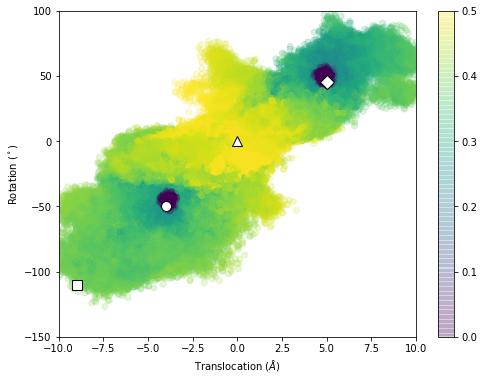

In [25]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(cvs[::10, 0], cvs[::10, 1], c=smooth[::10], alpha=0.2, cmap="viridis")
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

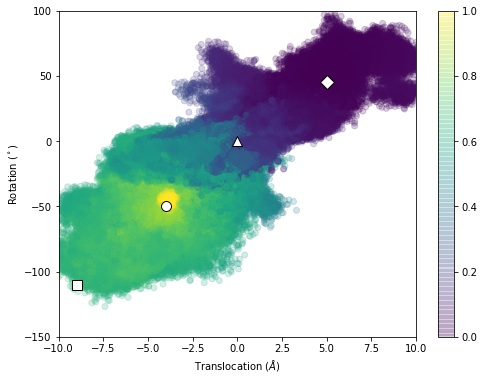

In [26]:
# Plot down state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cvs[::10, 0], cvs[::10, 1], c=guess_down[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

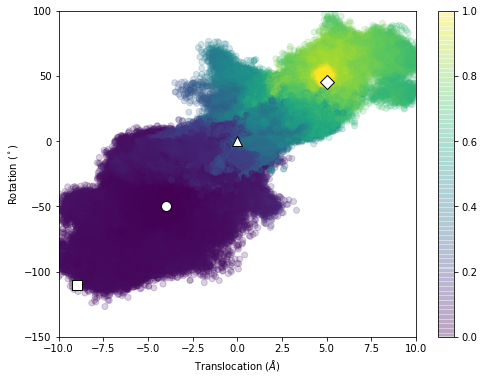

In [27]:
# Plot up state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(cvs[::10, 0], cvs[::10, 1], c=guess_up[::10], alpha=0.2, cmap="viridis")
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

In [28]:
importlib.reload(util)

<module 'util' from '../python/util.py'>

## Construct bases

In [30]:
basis_smooth = smooth * data_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=0.75)
basis_white[(mask == 0).flatten()] = 0

(6580000, 60)


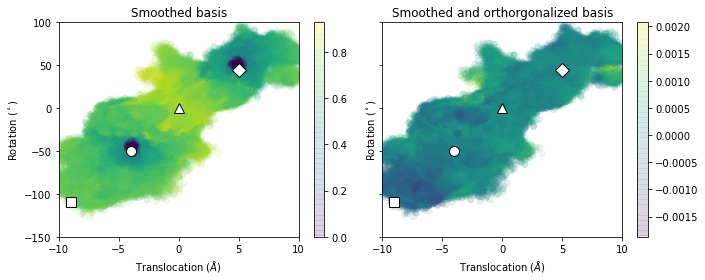

In [31]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    cvs[::10, 0],
    cvs[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
h2 = ax2.scatter(
    cvs[::10, 0],
    cvs[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

In [32]:
np.save("../data/feat2_local_duu/basis_white_feat2.npy", basis_white)
np.save("../data/feat2_local_duu/guess_down_feat2.npy", guess_down)
np.save("../data/feat2_local_duu/guess_up_feat2.npy", guess_up)

## Convert to lists of np arrays 

In [33]:
const = np.ones((len(data_arr), 1))
basisL_arr = np.hstack((const, data_arr))
basisF_arr = basis_white

# basisL = np.split(basisL_arr, traj_inds)
basisL = np.split(data_arr, traj_inds)
basisF = np.split(basisF_arr, traj_inds)
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(basisL), basisL[0].shape)
print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

1295 (3000, 60)
1295 (3000, 2)
1295
1295


# Change of Measure

In [34]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000]

In [35]:
weights = []
for lag in lags:
    com = extq.dga.reweight(data, lag)
    weights.append(com)

In [36]:
np.save("../data/feat2_local_duu/coms_feat2.npy", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# PMFs 

In [38]:
dens_all = []
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

for (com, lag) in zip(weights, lags):
    print(f"Density for lag {lag}")
    dens_all.append(extq.projection.density2d(dist_trajs, rot_trajs, com, xlim, ylim))

Density for lag 1
Density for lag 2
Density for lag 5
Density for lag 10
Density for lag 20
Density for lag 30
Density for lag 40
Density for lag 50
Density for lag 100
Density for lag 200
Density for lag 300
Density for lag 400
Density for lag 500
Density for lag 1000


# Committors

In [40]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000


In [41]:
np.save("../data/feat2_local_duu/q_du_feat2.npy", q_downup)
np.save("../data/feat2_local_duu/qb_du_feat2.npy", qb_downup)
np.save("../data/feat2_local_duu/q_ud_feat2.npy", q_updown)
np.save("../data/feat2_local_duu/qb_ud_feat2.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


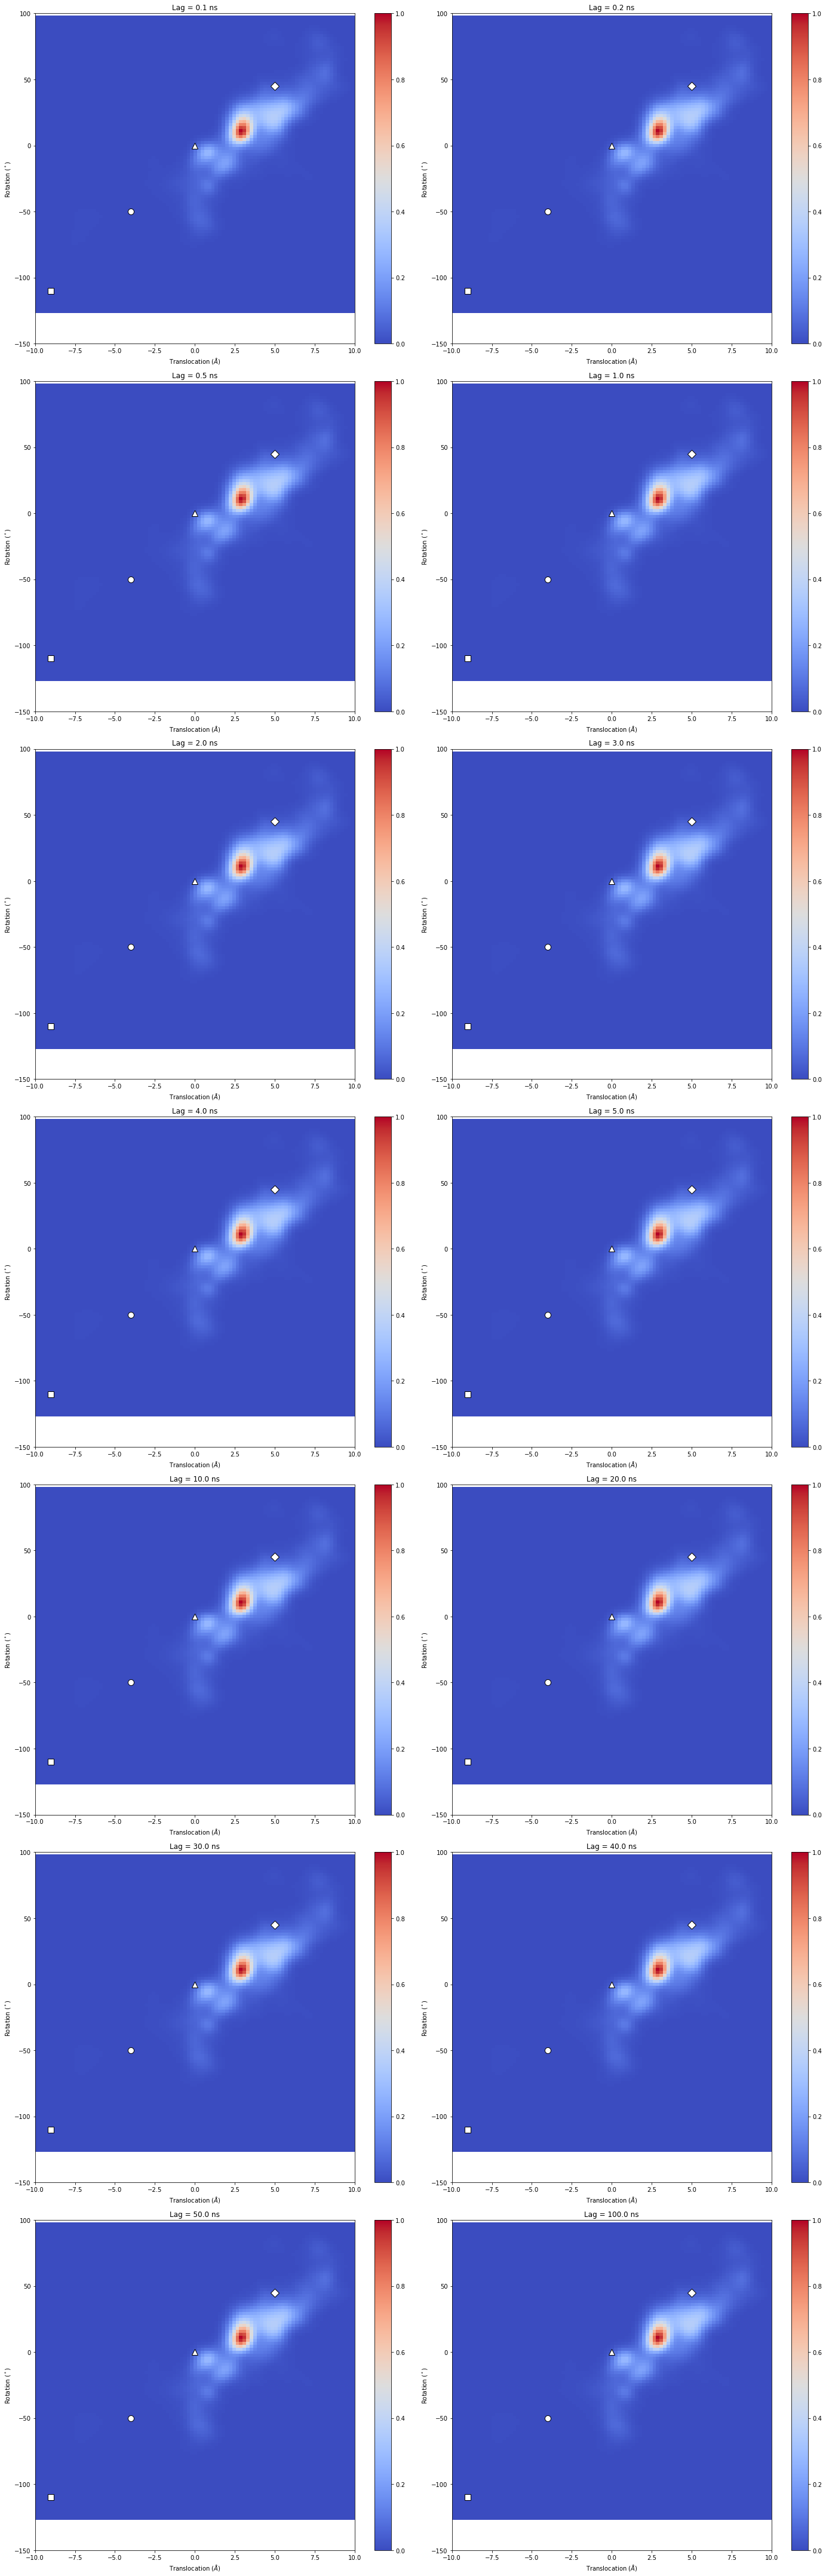

In [46]:
x = cvs[::10, 0]
y = cvs[::10, 1]

f, axs = plt.subplots(7, 2, figsize=(20, 60))

for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)[::10]
    q_kde, xedges, yedges = kde.kdesum2d(x, y, q_arr)
    #                                         xmin=-10.0, xmax=10.0,
    #                                         ymin=-150.0, ymax=100.0,
    #                                         xstd=0.05, ystd=0.5)
    h = ax.pcolor(xedges, yedges, q_kde / np.max(q_kde), cmap="coolwarm")
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()

In [48]:
from sklearn.neighbors import KernelDensity

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


ValueError: Expected 2D array, got 1D array instead:
array=[0.03491766 0.03366074 0.03542174 ... 0.10630932 0.08947928 0.10765372].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

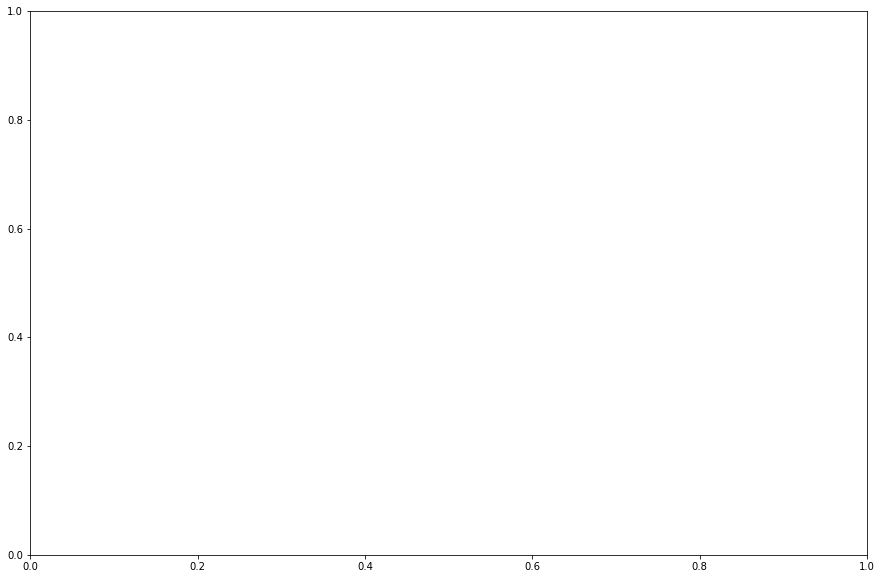

In [50]:
x = cvs[::10, 0]
y = cvs[::10, 1]

f, ax = plt.subplots(1,1, figsize=(15, 10))
q = q_downup[0]
q_arr = np.concatenate(q).reshape((-1, 1))
kd = KernelDensity(kernel='gaussian').fit(q_arr[])
#     h = ax.pcolor(xedges, yedges, q_kde / np.max(q_kde), cmap='coolwarm')
samples = kd.score_samples(cvs[::10,:])
h = ax.scatter(x, y, c=samples, cmap='coolwarm', alpha=0.2)
plt.colorbar(h, ax=ax)
ax.set_title(f'Lag = {lag * 0.1} ns')
util.format_cvs(ax)
    
f.tight_layout()

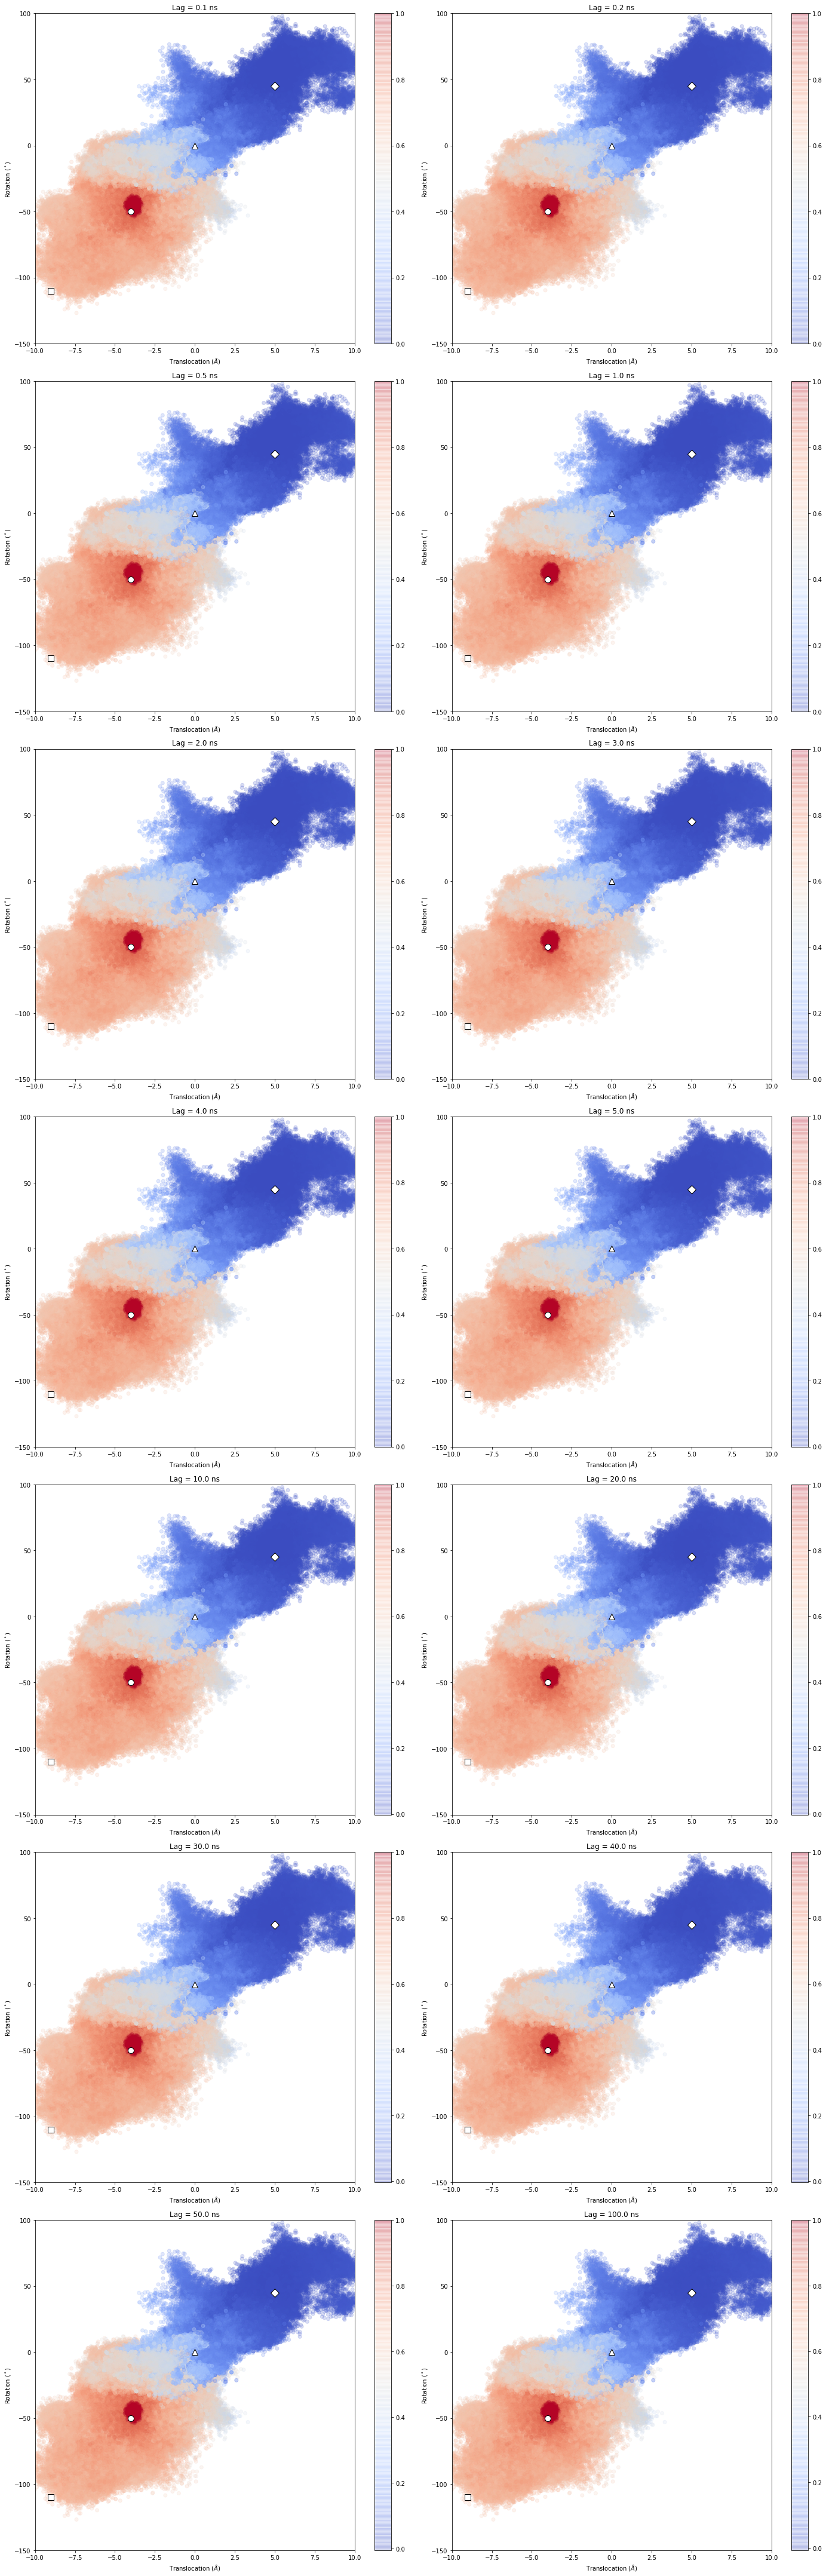

In [43]:
f, axs = plt.subplots(7, 2, figsize=(20, 60))
for lag, q, ax in zip(lags, q_updown, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cvs[::10, 0], cvs[::10, 1], c=q_arr[::10], cmap="coolwarm", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()

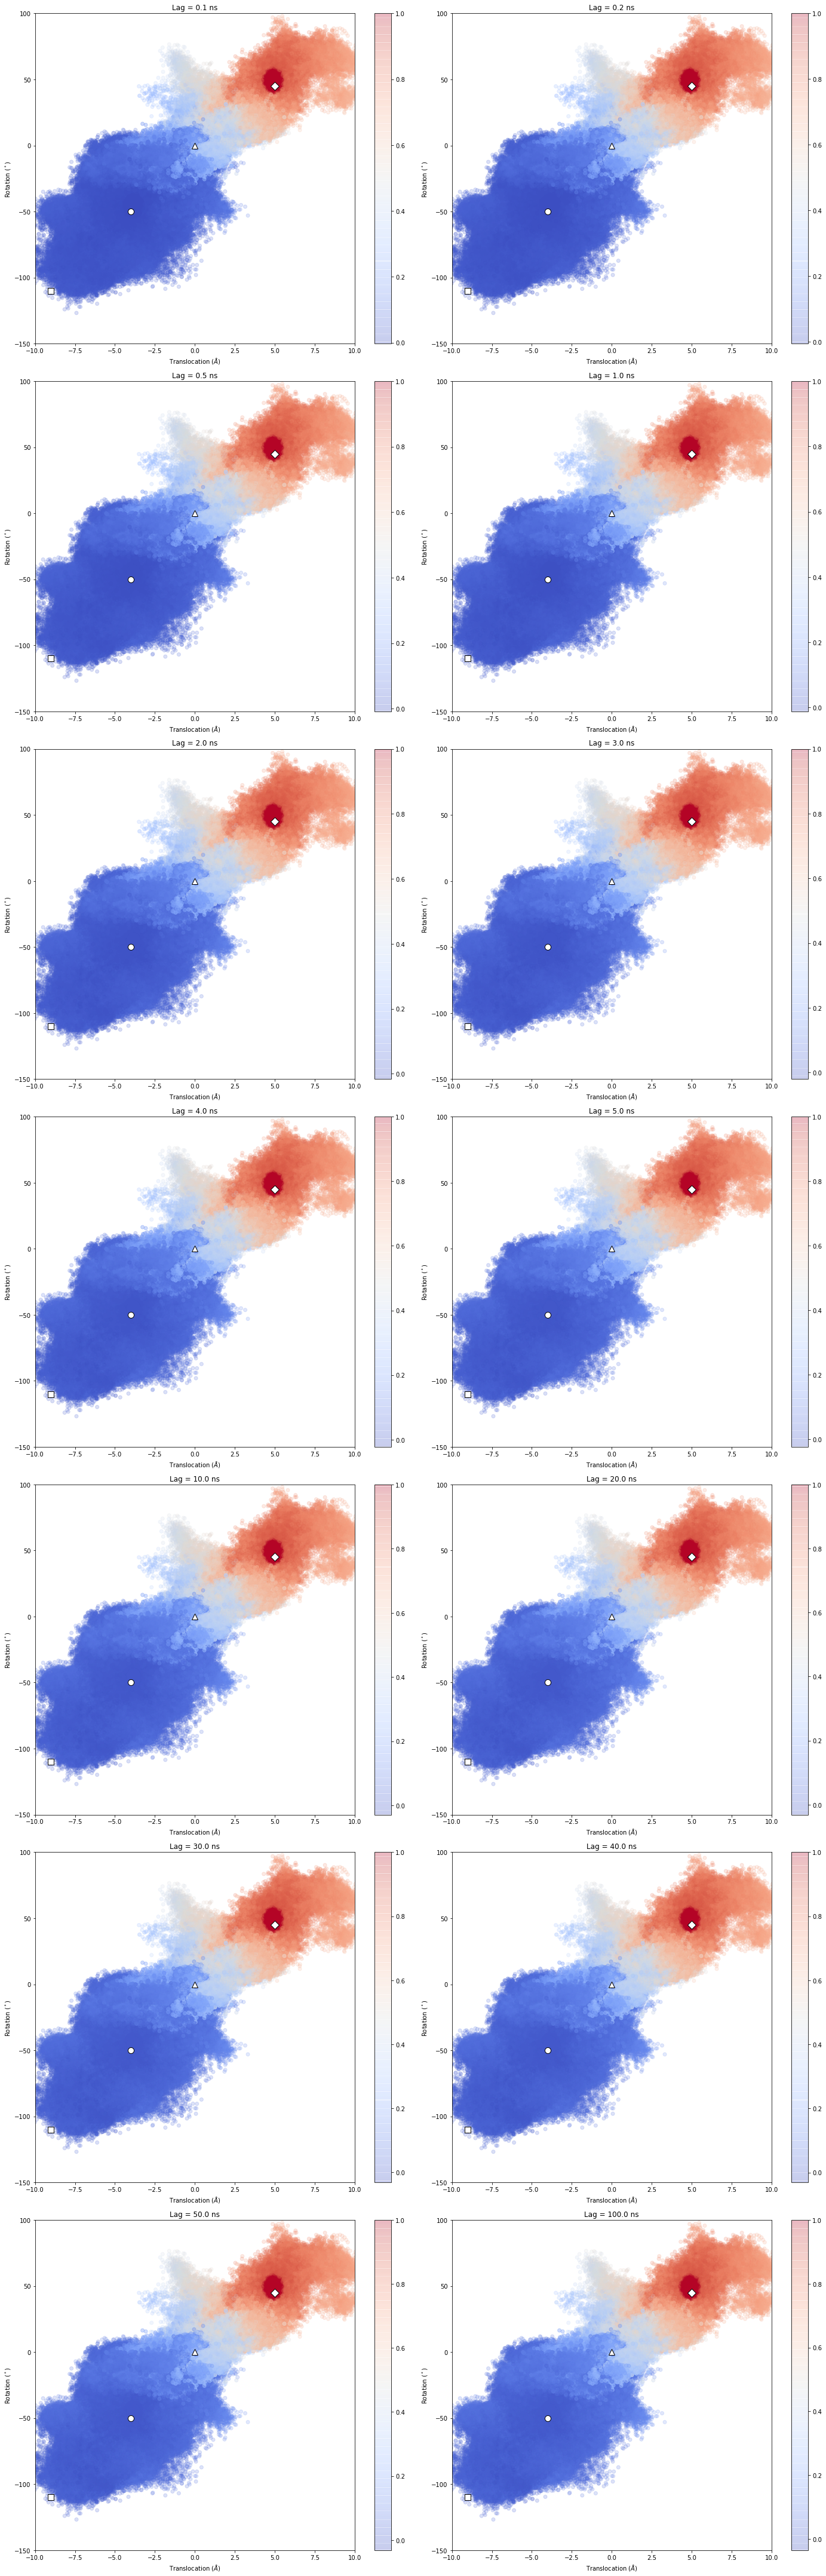

In [44]:
f, axs = plt.subplots(7, 2, figsize=(20, 60))
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cvs[::10, 0], cvs[::10, 1], c=q_arr[::10], cmap="coolwarm", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()